In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Generate synthetic dataset for Maharashtra travel destinations
def generate_travel_data(num_users=500, num_destinations=50):
    # List of popular Maharashtra destinations
    destinations = [
        "Gateway of India, Mumbai", "Ajanta Caves, Aurangabad", "Ellora Caves, Aurangabad",
        "Marine Drive, Mumbai", "Siddhivinayak Temple, Mumbai", "Shaniwar Wada, Pune",
        "Lonavala Hill Station", "Mahabaleshwar Hill Station", "Pratapgad Fort",
        "Raigad Fort", "Elephanta Caves, Mumbai", "Chhatrapati Shivaji Terminus, Mumbai",
        "Bibi Ka Maqbara, Aurangabad", "Tadoba Andhari Tiger Reserve", "Sanjay Gandhi National Park, Mumbai",
        "Ganpatipule Beach", "Alibaug Beach", "Matheran Hill Station", "Kaas Plateau, Satara",
        "Lavasa City, Pune", "Kolhapur Mahalaxmi Temple", "Trimbakeshwar Temple, Nashik",
        "Shirdi Sai Baba Temple", "Jejuri Khandoba Temple", "Mahad Raigad Fort",
        "Panhala Fort, Kolhapur", "Sinhagad Fort, Pune", "Rajmachi Fort, Lonavala",
        "Karla Caves, Lonavala", "Bhimashankar Temple", "Bhandardara Lake",
        "Malshej Ghat", "Toranmal Hill Station", "Chikhaldara Hill Station",
        "Amboli Hill Station", "Sawantwadi Palace", "Sindhudurg Fort", "Vijaydurg Fort",
        "Murud-Janjira Fort", "Aamby Valley, Lonavala", "Imagicaa Theme Park", "Water Kingdom, Mumbai",
        "EsselWorld, Mumbai", "Ramoji Film City, Hyderabad", "Lonar Crater Lake",
        "Pench National Park", "Nagzira Wildlife Sanctuary", "Temples of Paithan",
        "Nanded Gurudwara", "Ashtavinayak Temples"
    ]

    # Destination categories
    categories = [
        "Historical", "Religious", "Adventure", "Beach", "Hill Station",
        "Wildlife", "Fort", "Park", "Temple", "City Tour"
    ]

    # Generate destination metadata
    dest_data = []
    for i, dest in enumerate(destinations):
        # Extract location from destination name
        location = dest.split(', ')[1] if ', ' in dest else "Maharashtra"

        # Assign random categories
        num_categories = np.random.randint(1, 4)
        dest_categories = np.random.choice(categories, num_categories, replace=False)

        # Generate description based on categories
        if "Historical" in dest_categories:
            desc = f"Historical site in {location} with rich cultural heritage."
        elif "Religious" in dest_categories:
            desc = f"Important religious site in {location} for pilgrims."
        elif "Adventure" in dest_categories:
            desc = f"Adventure destination in {location} with exciting activities."
        elif "Beach" in dest_categories:
            desc = f"Beautiful beach destination in {location} with scenic views."
        elif "Hill Station" in dest_categories:
            desc = f"Picturesque hill station in {location} with pleasant climate."
        elif "Wildlife" in dest_categories:
            desc = f"Wildlife sanctuary in {location} with diverse flora and fauna."
        else:
            desc = f"Popular tourist destination in {location}."

        # Add more details based on categories
        if "Fort" in dest_categories:
            desc += " Ancient fort with architectural significance."
        if "Temple" in dest_categories:
            desc += " Sacred temple with spiritual importance."

        dest_data.append({
            'destination_id': i + 1,
            'name': dest,
            'location': location,
            'categories': ', '.join(dest_categories),
            'description': desc
        })

    destinations_df = pd.DataFrame(dest_data)

    # Generate user ratings
    ratings_data = []
    for user_id in range(1, num_users + 1):
        # Each user rates 10-40 destinations
        num_ratings = np.random.randint(10, 41)
        rated_destinations = np.random.choice(range(1, num_destinations + 1), num_ratings, replace=False)

        for dest_id in rated_destinations:
            # Base rating based on destination popularity (some destinations are generally more liked)
            base_rating = 3.5

            # Adjust rating based on destination ID (some destinations are more popular)
            if dest_id % 5 == 0:  # Every 5th destination is more popular
                base_rating += 0.5
            elif dest_id % 7 == 0:  # Every 7th destination is less popular
                base_rating -= 0.5

            # Add some random variation
            rating = np.random.normal(base_rating, 0.8)

            # Ensure rating is between 1 and 5
            rating = max(1, min(5, round(rating, 1)))

            ratings_data.append({
                'user_id': user_id,
                'destination_id': dest_id,
                'rating': rating
            })

    ratings_df = pd.DataFrame(ratings_data)

    return destinations_df, ratings_df

In [5]:
# Generate the dataset
print("Generating travel dataset for Maharashtra...")
destinations_df, ratings_df = generate_travel_data()

print(f"Generated {len(destinations_df)} destinations and {len(ratings_df)} ratings from {ratings_df['user_id'].nunique()} users")

Generating travel dataset for Maharashtra...
Generated 50 destinations and 12894 ratings from 500 users


In [6]:
# Display sample data
print("\nSample destinations:")
print(destinations_df.head(3))
print("\nSample ratings:")
print(ratings_df.head(3))


Sample destinations:
   destination_id                      name    location  \
0               1  Gateway of India, Mumbai      Mumbai   
1               2  Ajanta Caves, Aurangabad  Aurangabad   
2               3  Ellora Caves, Aurangabad  Aurangabad   

                        categories  \
0  Wildlife, Historical, City Tour   
1                       Historical   
2                  Fort, Adventure   

                                         description  
0  Historical site in Mumbai with rich cultural h...  
1  Historical site in Aurangabad with rich cultur...  
2  Adventure destination in Aurangabad with excit...  

Sample ratings:
   user_id  destination_id  rating
0        1               9     3.6
1        1              31     3.2
2        1              11     3.6


In [7]:
# Content-Based Filtering
print("\nBuilding Content-Based Filtering Model...")

# Create TF-IDF matrix from destination descriptions and categories
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(destinations_df['description'] + " " + destinations_df['categories'])

# Compute cosine similarity matrix
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)


Building Content-Based Filtering Model...


In [8]:
# Function to get content-based recommendations
def content_based_recommendations(destination_id, top_n=10):
    # Get the index of the destination
    idx = destinations_df[destinations_df['destination_id'] == destination_id].index[0]

    # Get similarity scores for all destinations
    sim_scores = list(enumerate(content_similarity[idx]))

    # Sort destinations based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N most similar destinations (excluding itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get destination indices
    destination_indices = [i[0] for i in sim_scores]

    # Return the top N most similar destinations
    return destinations_df.iloc[destination_indices]

In [9]:
# Collaborative Filtering using Matrix Factorization
print("Building Collaborative Filtering Model...")

# Create user-item matrix
user_item_matrix = ratings_df.pivot_table(index='user_id', columns='destination_id', values='rating').fillna(0)

# Normalize the data
user_item_matrix_norm = user_item_matrix - user_item_matrix.mean(axis=1).values.reshape(-1, 1)

# Apply SVD for matrix factorization
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(user_item_matrix_norm)
item_features = svd.components_.T

# Reconstruct the matrix
predicted_ratings = np.dot(user_features, item_features.T) + user_item_matrix.mean(axis=1).values.reshape(-1, 1)

# Convert back to DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings,
                                   index=user_item_matrix.index,
                                   columns=user_item_matrix.columns)

Building Collaborative Filtering Model...


In [10]:
# Function to get collaborative filtering recommendations
def collaborative_recommendations(user_id, top_n=10):
    # Get predicted ratings for the user
    user_ratings = predicted_ratings_df.loc[user_id]

    # Get destinations already rated by the user
    rated_destinations = ratings_df[ratings_df['user_id'] == user_id]['destination_id'].values

    # Filter out already rated destinations
    recommendations = user_ratings[~user_ratings.index.isin(rated_destinations)]

    # Sort by predicted rating
    recommendations = recommendations.sort_values(ascending=False)

    # Get top N recommendations
    top_recommendations = recommendations.head(top_n)

    # Return destination details
    return destinations_df[destinations_df['destination_id'].isin(top_recommendations.index)]

In [11]:
# Hybrid Recommendation System
print("Building Hybrid Recommendation System...")

def hybrid_recommendations(user_id, destination_id=None, top_n=10, content_weight=0.4, collab_weight=0.6):
    # If no destination_id provided, use the highest rated destination by the user
    if destination_id is None:
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        if len(user_ratings) > 0:
            destination_id = user_ratings.sort_values('rating', ascending=False).iloc[0]['destination_id']
        else:
            # If user has no ratings, use most popular destination
            destination_id = ratings_df.groupby('destination_id')['rating'].mean().sort_values(ascending=False).index[0]

    # Get content-based recommendations
    content_recs = content_based_recommendations(destination_id, top_n*3)
    content_recs['content_score'] = range(len(content_recs), 0, -1)  # Higher score for better recommendations

    # Get collaborative filtering recommendations
    collab_recs = collaborative_recommendations(user_id, top_n*3)
    collab_recs = collab_recs.merge(
        predicted_ratings_df.loc[user_id].reset_index(),
        left_on='destination_id', right_on='destination_id'
    )
    collab_recs.rename(columns={user_id: 'collab_score'}, inplace=True)

    # Merge the two recommendation sets
    hybrid_recs = pd.merge(
        content_recs[['destination_id', 'content_score']],
        collab_recs[['destination_id', 'collab_score']],
        on='destination_id',
        how='outer'
    ).fillna(0)

    # Normalize scores
    scaler = MinMaxScaler()
    hybrid_recs['content_score_norm'] = scaler.fit_transform(hybrid_recs[['content_score']])
    hybrid_recs['collab_score_norm'] = scaler.fit_transform(hybrid_recs[['collab_score']])

    # Calculate hybrid score
    hybrid_recs['hybrid_score'] = (content_weight * hybrid_recs['content_score_norm'] +
                                  collab_weight * hybrid_recs['collab_score_norm'])

    # Sort by hybrid score
    hybrid_recs = hybrid_recs.sort_values('hybrid_score', ascending=False)

    # Get top N recommendations
    top_hybrid = hybrid_recs.head(top_n)

    # Merge with destination details
    result = top_hybrid.merge(destinations_df, on='destination_id')

    return result[['destination_id', 'name', 'location', 'categories', 'hybrid_score']]

Building Hybrid Recommendation System...


In [12]:
# Evaluation
print("Evaluating the recommendation system...")

# Split ratings into train and test sets
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Create train user-item matrix
train_matrix = train_ratings.pivot_table(index='user_id', columns='destination_id', values='rating').fillna(0)

# Normalize the train data
train_matrix_norm = train_matrix - train_matrix.mean(axis=1).values.reshape(-1, 1)

# Apply SVD on train data
svd_train = TruncatedSVD(n_components=n_components, random_state=42)
user_features_train = svd_train.fit_transform(train_matrix_norm)
item_features_train = svd_train.components_.T

# Reconstruct the matrix
predicted_ratings_train = np.dot(user_features_train, item_features_train.T) + train_matrix.mean(axis=1).values.reshape(-1, 1)

# Calculate RMSE for collaborative filtering
test_matrix = test_ratings.pivot_table(index='user_id', columns='destination_id', values='rating').fillna(0)

# Align test matrix with train matrix
test_matrix_aligned = test_matrix.reindex(index=train_matrix.index, columns=train_matrix.columns, fill_value=0)

# Calculate RMSE
y_true = []
y_pred = []
for _, row in test_ratings.iterrows():
    user_id = row['user_id']
    dest_id = row['destination_id']

    if user_id in train_matrix.index and dest_id in train_matrix.columns:
        y_true.append(row['rating'])
        y_pred.append(predicted_ratings_train[train_matrix.index.get_loc(user_id),
                                             train_matrix.columns.get_loc(dest_id)])

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Collaborative Filtering RMSE: {rmse:.4f}")

# Evaluate precision and recall for hybrid recommendations
def evaluate_hybrid(top_k=10):
    # For a sample of users
    sample_users = ratings_df['user_id'].unique()[:50]  # Use first 50 users for evaluation

    precisions = []
    recalls = []

    for user_id in sample_users:
        # Get user's highly rated destinations (rating >= 4)
        user_high_ratings = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
        relevant_items = set(user_high_ratings['destination_id'].values)

        if len(relevant_items) == 0:
            continue

        # Get hybrid recommendations
        hybrid_recs = hybrid_recommendations(user_id, top_n=top_k)
        recommended_items = set(hybrid_recs['destination_id'].values)

        # Calculate precision and recall
        if len(recommended_items) > 0:
            true_positives = len(relevant_items.intersection(recommended_items))
            precision = true_positives / len(recommended_items)
            recall = true_positives / len(relevant_items)

            precisions.append(precision)
            recalls.append(recall)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    return avg_precision, avg_recall

Evaluating the recommendation system...
Collaborative Filtering RMSE: 3.6243


Precision@5: 0.1480, Recall@5: 0.0824
Precision@10: 0.1500, Recall@10: 0.1804
Precision@15: 0.1613, Recall@15: 0.2899

Sample Recommendations for User 1:
                                   name     location  \
0                    Temples of Paithan  Maharashtra   
1                 Matheran Hill Station  Maharashtra   
2              Gateway of India, Mumbai       Mumbai   
3            Mahabaleshwar Hill Station  Maharashtra   
4                   Imagicaa Theme Park  Maharashtra   
5              Ajanta Caves, Aurangabad   Aurangabad   
6                         Alibaug Beach  Maharashtra   
7                Jejuri Khandoba Temple  Maharashtra   
8                Aamby Valley, Lonavala     Lonavala   
9  Chhatrapati Shivaji Terminus, Mumbai       Mumbai   

                        categories  hybrid_score  
0      Adventure, Historical, Fort      0.893333  
1                       Historical      0.858824  
2  Wildlife, Historical, City Tour      0.849412  
3            Historical, 

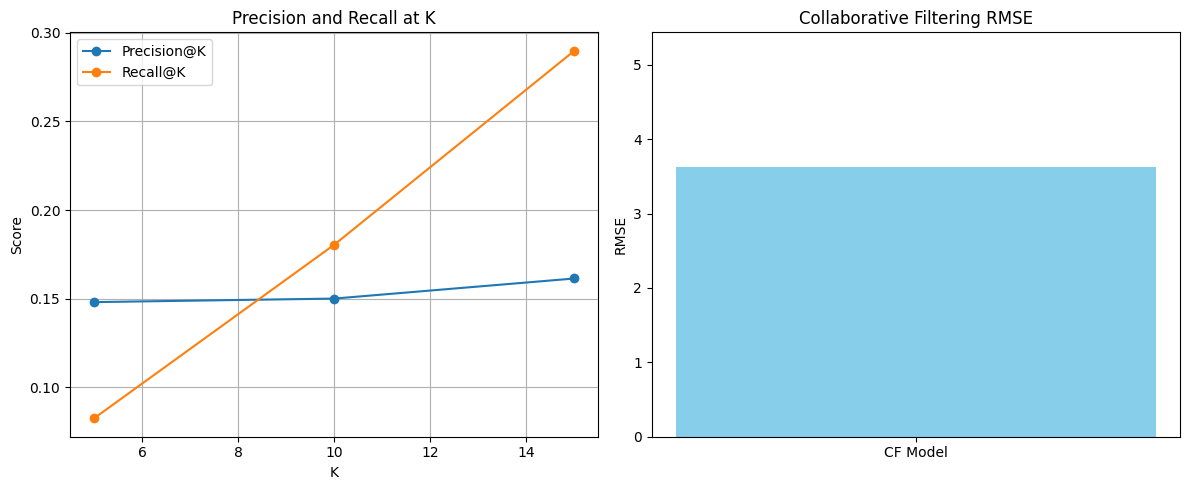


Recommendation system implementation completed!
Metrics visualization saved as 'recommendation_metrics.png'


In [13]:
# Evaluate for different values of K
k_values = [5, 10, 15]
results = {}

for k in k_values:
    precision, recall = evaluate_hybrid(top_k=k)
    results[k] = {'Precision': precision, 'Recall': recall}
    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")

# Generate sample recommendations
print("\nSample Recommendations for User 1:")
user_id = 1
sample_recommendations = hybrid_recommendations(user_id, top_n=10)
print(sample_recommendations[['name', 'location', 'categories', 'hybrid_score']])

# Visualization
plt.figure(figsize=(12, 5))

# Plot Precision@K and Recall@K
plt.subplot(1, 2, 1)
precisions = [results[k]['Precision'] for k in k_values]
recalls = [results[k]['Recall'] for k in k_values]
plt.plot(k_values, precisions, marker='o', label='Precision@K')
plt.plot(k_values, recalls, marker='o', label='Recall@K')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Precision and Recall at K')
plt.legend()
plt.grid(True)

# Plot RMSE
plt.subplot(1, 2, 2)
plt.bar(['CF Model'], [rmse], color='skyblue')
plt.ylabel('RMSE')
plt.title('Collaborative Filtering RMSE')
plt.ylim(0, max(rmse * 1.5, 1))

plt.tight_layout()
plt.savefig('recommendation_metrics.png')
plt.show()

print("\nRecommendation system implementation completed!")
print("Metrics visualization saved as 'recommendation_metrics.png'")